<h1 align="center"> The Framework to calculate Richness v2 

<center>
<img src="./static/framework0.png">
</center>


In [1]:
import pandas as pd
import numpy as np
import math,os,sys

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style(style= 'darkgrid')
%matplotlib inline

In [2]:
CSV_PATH = r"""C:\Users\M1049231\Downloads\UCI_Credit_Card.csv"""

In [3]:
raw = pd.read_csv(CSV_PATH)

<p style="color:red;">Columns in the dataset </p>
<hr>
<p style="color:gray;">'ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', </p> 
<p style="color:gray;">'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',  </p>
<p style="color:gray;">'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', </p>
<p style="color:gray;">'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6',  </p>
<p style="color:gray;">'default.payment.next.month'</p>


In [4]:
"""DEPRICATED: 23/ 25 columns will be used as features in an idea scenario"""
# FEAT_COLUMNS = list(raw.columns.values)[1:-1] 

"""the Target variable"""
TARGET_COLUMN = list(raw.columns.values)[-1]

"""Financial data"""
FEAT_COLUMN = list(raw.columns.values)[12:-1] 

"""Initialize feature importance of various features in FEAT_COLUMN"""
FEAT_WEIGHT_MAP = {col:1/len(FEAT_COLUMN) for col in FEAT_COLUMN}

In [5]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print(f'func: {f.__name__} took: {te-ts} sec')
        return result
    return wrap

In [6]:
raw.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
def get_ssn(n:int, indv:int=10000):
    """Random generation of SSN in the range 1 to indv individuals """
    
    print(f"the ratio of indv to population is : {indv/n}")
    print(f"the ratio of population to  indv is : {n/indv}")
    return [np.random.randint(1,(indv+1)) for i in range(n)]

In [8]:
if 'SSN' in raw.columns:
    if input('do you want to delete SSN columns (y/n): ') == 'y':
        raw.drop('SSN',axis = 1, inplace = True)

raw.insert(0,'SSN', get_ssn(n= len(raw), indv = 13000))

the ratio of indv to population is : 0.43333333333333335
the ratio of population to  indv is : 2.3076923076923075


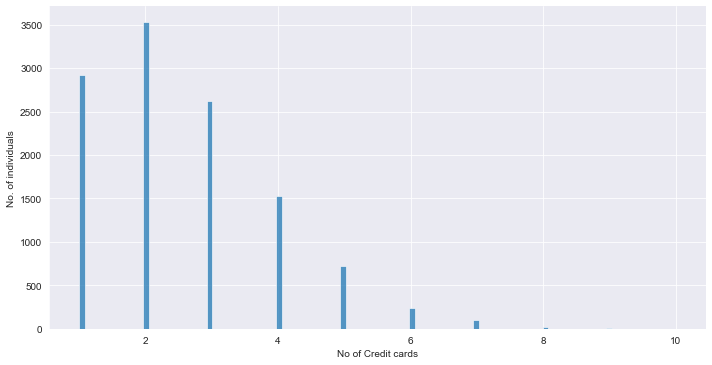

In [9]:
"""having a look at the new distribution of SSIDs. Now we have duplicate ssids which means one-to-many 
mapping between individual and no. active credit cards. we also notice that the there are 2466 individuals with 
1 card and ~3k with 2 cards. these categories represent the thin files in our dataset """

counsdf = raw.groupby('SSN').size()
g = sns.displot(counsdf , kind = 'hist', height = 5, aspect = 2)
g.set_axis_labels("No of Credit cards", "No. of individuals")

<h3> Calculating the richness of each datapoint

In [10]:
def _row_richness(df, FEAT_COLUMN):
    """This funtion helps us assign richness to each data point in the a dataset FEAT_COLUMN 
    represents the Columns that impact our score the most, Future updates can include weights 
    illustrating the  importance of the """
    
    full_health = len(FEAT_COLUMN)
    health = sum(df[FEAT_COLUMN].values != 0)
    return(health/full_health)                          
    
def new_row_richness(df, FEAT_WEIGHT_MAP:dict):
    """This funtion helps us assign richness to each data point in the a dataset FEAT_COLUMN 
    represents the Columns that impact our score the most, Future updates can include weights 
    illustrating the  importance of the """
    
    magnitude = 0
    for col in list(FEAT_WEIGHT_MAP.keys()):
        if df[col]!=0:
            magnitude += FEAT_WEIGHT_MAP[col]

    return magnitude.__round__(2)

In [15]:
if 'richness' in raw.columns:
    print("removed richness column, populating now...")
    raw.drop('richness',axis = 1, inplace = True)
# raw.insert(1,'richness', raw.apply(_row_richness,FEAT_WEIGHT_MAP=FEAT_WEIGHT_MAP ,axis = 1))
raw.insert(1,'richness', raw.apply(_row_richness,FEAT_COLUMN=FEAT_COLUMN ,axis = 1))

removed richness column, populating now...


In [16]:
def _ssn_slim_file(counsdf, slimness:int = 1):
    li = (counsdf[counsdf.values==slimness]).index.tolist()
    return li

SSN_SLIM_FILE = _ssn_slim_file(counsdf)
print(f"number of slim file SSN\'s : {len(SSN_SLIM_FILE)}")
slim_file_df = raw[raw['SSN'].isin(SSN_SLIM_FILE)]
print(f"number of slim files found : {len(slim_file_df)}")
assert len(SSN_SLIM_FILE) == len(slim_file_df), "check the value counts"

number of slim file SSN's : 2919
number of slim files found : 2919


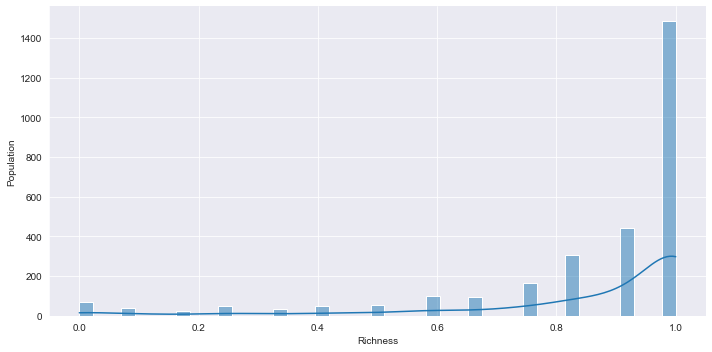

In [17]:
"""Having a look at the richness of out slim files to identify a cut of that might help
in identifying any thin files in the dataset !! ['hist', 'kde', 'ecdf'] """

g = sns.displot(slim_file_df['richness'] , kind = 'hist', height = 5, aspect = 2, kde = True)
g.set_axis_labels("Richness", "Population")

In [18]:
print(f"Files with richness less than 50% :{slim_file_df[slim_file_df['richness'] <0.5].shape[0]}")

Files with richness less than 50% :264


<h3 style="color:Green"> Having a look at the richness of the whole population

In [19]:
raw.columns

Index(['SSN', 'richness', 'ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE',
       'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default.payment.next.month'],
      dtype='object')

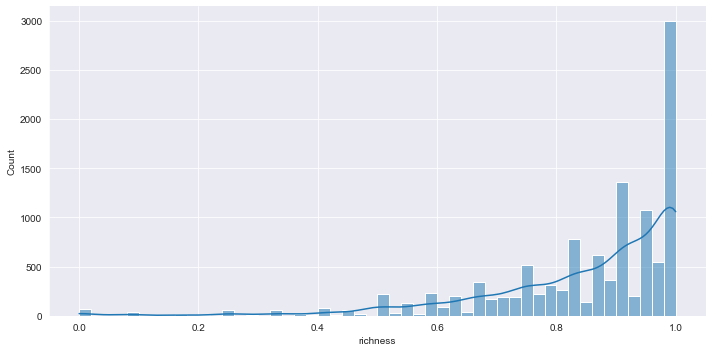

In [20]:
""" Individuals with only one credit line is considered for this experiment, but we can also consider individuals for 2 > too
which shows that the inactive nature of the multiple lines of credit."""

raw_richness_map = raw.groupby('SSN')['richness'].mean()
sns.displot(raw_richness_map, kind="hist", kde=True, height = 5, aspect = 2)

In [21]:
print(f"Files with richness less than 50% :  {raw_richness_map[raw_richness_map<0.5].shape[0]}")

Files with richness less than 50% :  462


<h3 style="color:green;">The alternate data set:

In [22]:
def generate_data_quad(rows):
    x_array = []
    id = 1
    while len(x_array) < rows:
        a = float(np.random.randint(-10, 10))
        b = float(np.random.randint(-10, 10))
        c = float(np.random.randint(-10, 10))
        y = [0, 0]

        try:
            y = [
                (-b + math.sqrt((b * b) - (4 * a * c))) / (2 * a),
                (-b - math.sqrt((b * b) - (4 * a * c))) / (2 * a)]
        except (ValueError, ZeroDivisionError):
            pass

        x_array.append([id, a, b, c, abs(y[0] - y[1])])
        id += 1
    return np.array(x_array)

In [23]:
def _add_list_to_df(df:pd.DataFrame,li:list):
    
    df_ix = len(df)
    for row in li:
        df.loc[df_ix] = row
        df_ix += 1
    
    return df

In [24]:
x = generate_data_quad(13000)
alt_df_raw = pd.DataFrame(columns=['SSN', 'x1', 'x2', 'x3', 'x4'])
alt_df_raw = _add_list_to_df(alt_df_raw, x)
alt_df_raw.SSN = alt_df_raw.SSN.astype('int32')

In [25]:
alt_df_raw.head()

,SSN,x1,x2,x3,x4
0,1,8.0,-8.0,-6.0,2.000000
1,2,8.0,-1.0,2.0,0.000000
2,3,-9.0,6.0,-10.0,0.000000
3,4,3.0,1.0,-9.0,3.480102
4,5,-1.0,-2.0,0.0,2.000000


<AxesSubplot:xlabel='x4', ylabel='Density'>

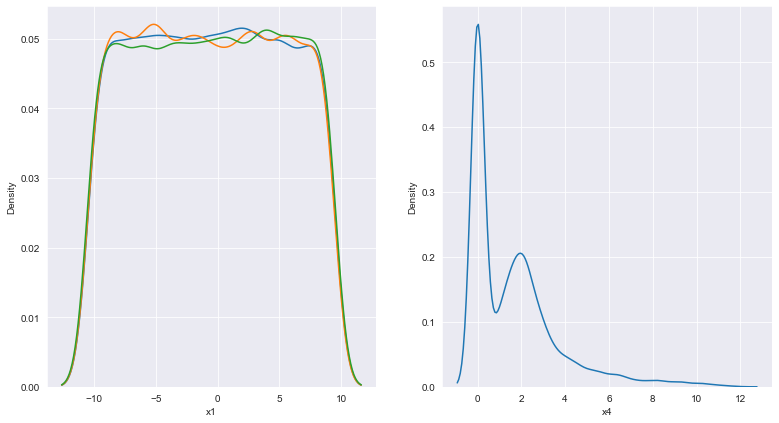

In [26]:
fig,ax = plt.subplots(1,2,figsize=(13, 7))
for i in [ 'x1', 'x2', 'x3']:
    sns.kdeplot(alt_df_raw[i], ax = ax[0])
sns.kdeplot(alt_df_raw.x4, ax = ax[1])

In [27]:
def _induce_null(col:list, df:pd.DataFrame, prob = 10):
    for i in range(len(col)):
        rand = np.random.randint(0,100)
        if rand>prob:
            df[col[i]] = 0
    return df

In [28]:
alt_df_raw.insert(1,'alt_richness', alt_df_raw.apply(_row_richness,FEAT_COLUMN=['x1', 'x2', 'x3', 'x4'] ,axis = 1))

In [29]:
alt_df_raw.head()

,SSN,alt_richness,x1,x2,x3,x4
0,1,1.00,8.0,-8.0,-6.0,2.000000
1,2,0.75,8.0,-1.0,2.0,0.000000
2,3,0.75,-9.0,6.0,-10.0,0.000000
3,4,1.00,3.0,1.0,-9.0,3.480102
4,5,0.75,-1.0,-2.0,0.0,2.000000


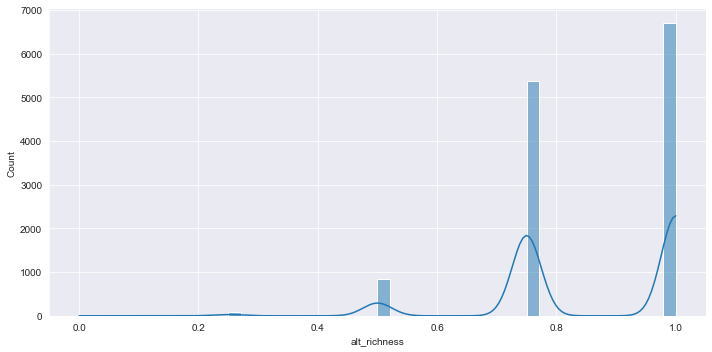

In [30]:
alt_ssn_richness = alt_df_raw.groupby('SSN')['alt_richness'].mean()
sns.displot(alt_ssn_richness, kind="hist", kde=True,height = 5, aspect = 2)

In [31]:
print(f"Files with richness less than 50% :  {alt_ssn_richness[alt_ssn_richness<0.5].shape[0]}")

Files with richness less than 50% :  87


In [32]:
type(alt_ssn_richness)

pandas.core.series.Series

In [33]:
from functools import partial

In [34]:
def _generate_weighted_richness(df_raw, alt_ssn_map:dict, alt_col:str = "alt_richness", raw_col:str = "richness", weightage:dict={"raw":0.5,"alt":0.5}):
    # print(df_raw)
    # import pdb;pdb.set_trace()
    res = alt_ssn_map[df_raw['SSN']]*weightage['alt'] + df_raw[raw_col]*weightage['raw']
    return [df_raw['SSN'], df_raw[raw_col], res] #['SSN',"baseline_richness","new_richness"]

def generate_weighted_richness_wrapper(raw,alt_ssn_richness):
    res = []
    generate = partial(_generate_weighted_richness, alt_ssn_map=alt_ssn_richness.to_dict())
    for i in raw.index:
        res.append(generate({'SSN':i,'richness':raw[i]}))
    return res


In [35]:
# raw_richness_map.apply(_generate_weighted_richness, alt_ssn_map = alt_ssn_richness.to_dict())

In [37]:
_ = generate_weighted_richness_wrapper(raw = raw_richness_map, alt_ssn_richness=alt_ssn_richness)
merged_richness = pd.DataFrame(_, columns= ['SSN',"baseline_richness","new_richness"])


<AxesSubplot:xlabel='new_richness', ylabel='Density'>

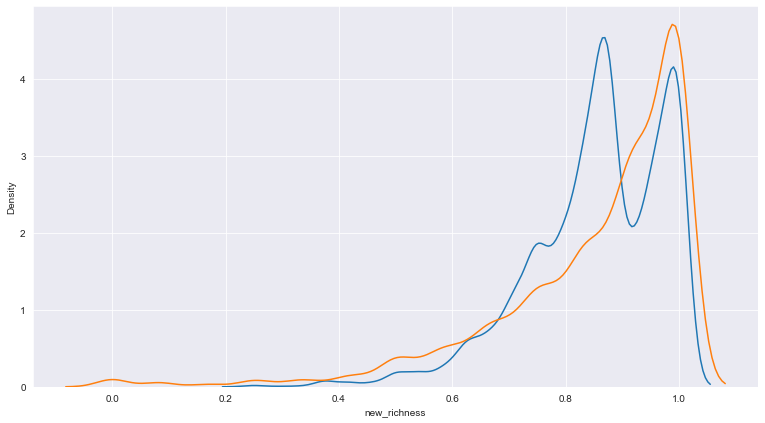

In [38]:
fig,ax = plt.subplots(figsize=(13, 7))
sns.kdeplot(merged_richness["new_richness"], ax = ax)
sns.kdeplot(merged_richness["baseline_richness"], ax = ax)

In [39]:
print(f"Files with BASELINE richness less than 50% :  {raw_richness_map[raw_richness_map<0.5].shape[0]}")
print(f"Files in MERGED dataset with richness less than 50% :{merged_richness[merged_richness['new_richness'] <0.5].shape[0]}")

Files with BASELINE richness less than 50% :  462
Files in MERGED dataset with richness less than 50% :114
